<a href="https://colab.research.google.com/github/ikabrain/MiniProject01/blob/main/ML_assign8/ML_assign8.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Lab Assignment 8: Adaboost

---


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

## **Q1. SMS Spam Collection Dataset**

---


Use the **SMS Spam Collection Dataset**

(Source: UCI / Kaggle → spam.csv)

**Task**

Classify SMS messages as:

- spam (1)
- ham (0) — not spam

**Data Description**

| Column | Meaning             |
| ------ | ------------------- |
| label  | spam / ham          |
| text   | SMS message content |

There are $\sim$5,500 messages


### **Part A — Data Preprocessing & Exploration**


#### 1. Load the SMS spam dataset


In [ ]:
%%bash
if [ -e "spam.csv" ] && [ -s "spam.csv" ]; then
    echo "The file exists and is not empty."
else
    echo "The file either does not exist or is empty. Downloading file from UCI archive..."

    # Download dataset
    curl -Ls -o spam.zip https://archive.ics.uci.edu/static/public/228/sms+spam+collection.zip
    unzip -q -o spam.zip
    rm spam.zip readme

    # Convert to proper CSV with quoted text field
    awk 'BEGIN { FS="\t"; OFS="," }
        { gsub(/"/, "\"\"", $2); print $1, "\"" $2 "\"" }' SMSSpamCollection \
        > spam.csv
    rm SMSSpamCollection

    # Prepend header
    sed -i '1i label,text' spam.csv

    echo "spam.csv downloaded."
fi

The file either does not exist or is empty. Downloading file from UCI archive...
spam.csv downloaded.


In [ ]:
df = pd.read_csv("spam.csv")
df.head()

,label,text
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


#### 2. Convert label: "spam" → 1, "ham" → 0


In [ ]:
df_encoded = df.copy(deep=True)

df_encoded["label"] = df["label"].map({"spam": 1, "ham": 0})
df_encoded.head()

,label,text
0,0,"Go until jurong point, crazy.. Available only ..."
1,0,Ok lar... Joking wif u oni...
2,1,Free entry in 2 a wkly comp to win FA Cup fina...
3,0,U dun say so early hor... U c already then say...
4,0,"Nah I don't think he goes to usf, he lives aro..."


#### 3. Text preprocessing:

- Lowercase
- Remove punctuation
- Remove stopwords


In [ ]:
import nltk
from nltk.corpus import stopwords
import string

# Download stopwords if not already downloaded
try:
    stopwords.words("english")
except LookupError:
    nltk.download("stopwords", quiet=True)

In [ ]:
def preprocess_text(text):
    # Lowercase
    text = text.lower()
    # Remove punctuation
    text = "".join([char for char in text if char not in string.punctuation])
    # Remove stopwords
    words = text.split()
    words = [word for word in words if word not in stopwords.words("english")]
    return " ".join(words)

In [ ]:
df_preprocess = df_encoded.copy(deep=True)

df_preprocess["text"] = df_encoded["text"].apply(preprocess_text)

df_preprocess.head()

,label,text
0,0,go jurong point crazy available bugis n great ...
1,0,ok lar joking wif u oni
2,1,free entry 2 wkly comp win fa cup final tkts 2...
3,0,u dun say early hor u c already say
4,0,nah dont think goes usf lives around though


#### 4. Convert text to numeric feature vectors using **TF-IDF vectorizer**


In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf_vectorizer = TfidfVectorizer()
X_tfidf = tfidf_vectorizer.fit_transform(df_preprocess["text"])

print(f"Shape of TF-IDF matrix: {X_tfidf.shape}")

Shape of TF-IDF matrix: (5574, 9437)


#### 5. Train–test split (80/20)


In [ ]:
from sklearn.model_selection import train_test_split

X = X_tfidf
y = df_preprocess["label"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

print(f"Training records: {X_train.shape[0]}")
print(f" Testing records: {X_test.shape[0]}")

Training records: 4459
 Testing records: 1115


#### 6. Show class distribution


In [ ]:
class_distribution = y.value_counts()

class_distribution

,count
label,
0,4827
1,747


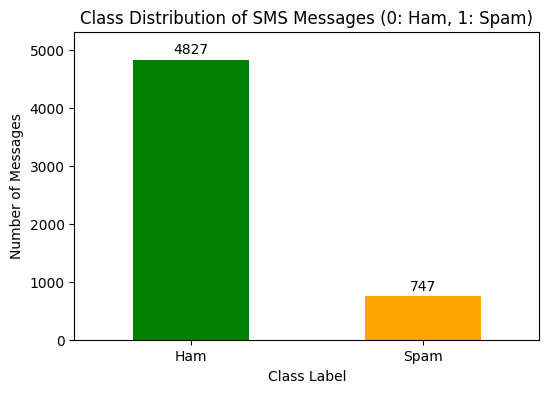

In [ ]:
plt.figure(figsize=(6, 4))
ax = class_distribution.plot(kind="bar", color=["green", "orange"])
plt.title("Class Distribution of SMS Messages (0: Ham, 1: Spam)")
plt.xlabel("Class Label")
plt.ylabel("Number of Messages")
plt.xticks(ticks=[0, 1], labels=["Ham", "Spam"], rotation=0)
plt.ylim(0, 1.1 * class_distribution.max())

# Add exact counts above the bars
for i, count in enumerate(class_distribution):
    ax.text(i, count + 50, str(count), ha="center", va="bottom")

plt.show()

### **Part B — Weak Learner Baseline**


#### 1. Train a **Decision Stump**:

`DecisionTreeClassifier(max_depth=1)`


In [ ]:
# Train a Decision Stump
from sklearn.tree import DecisionTreeClassifier

stump = DecisionTreeClassifier(max_depth=1, random_state=42)
stump.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=1, random_state=42)

#### 2. Report:

- Train accuracy
- Test accuracy
- Confusion matrix
- Comment on why stump performance is weak on text data


In [ ]:
y_pred_stump_train = stump.predict(X_train)
y_pred_stump_test = stump.predict(X_test)

In [ ]:
# Calculating accuracies
from sklearn.metrics import accuracy_score

stump_train_accuracy = accuracy_score(y_train, y_pred_stump_train)
stump_test_accuracy = accuracy_score(y_test, y_pred_stump_test)

print("FOR SINGLE DECISION STUMP:-")
print(f"\tTrain accuracy: {stump_train_accuracy:.4f}")
print(f"\t Test accuracy: {stump_test_accuracy:.4f}")

FOR SINGLE DECISION STUMP:-
	Train accuracy: 0.8847
	 Test accuracy: 0.8861


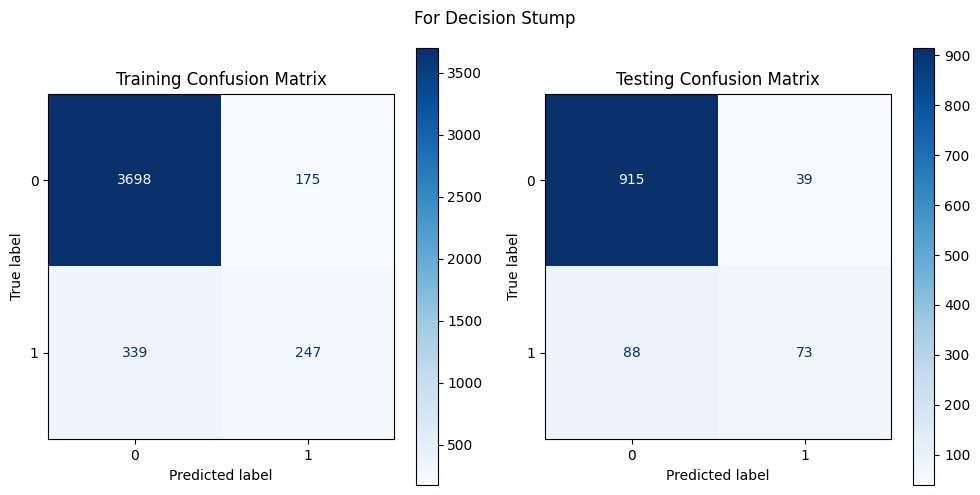

In [ ]:
# Confusion matrices
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm_stump_train = confusion_matrix(y_train, y_pred_stump_train)
cm_stump_test = confusion_matrix(y_test, y_pred_stump_test)

plt.figure(figsize=(10, 5))

plt.suptitle("For Decision Stump")

plt.subplot(1, 2, 1)
disp_stump_train = ConfusionMatrixDisplay(
    confusion_matrix=cm_stump_train, display_labels=stump.classes_
)
disp_stump_train.plot(cmap=plt.cm.Blues, ax=plt.gca())
plt.title("Training Confusion Matrix")

plt.subplot(1, 2, 2)
disp_stump_test = ConfusionMatrixDisplay(
    confusion_matrix=cm_stump_test, display_labels=stump.classes_
)
disp_stump_test.plot(cmap=plt.cm.Blues, ax=plt.gca())
plt.title("Testing Confusion Matrix")

plt.tight_layout()
plt.show()

As expected, the baseline decision stump performs weakly on the text data, as:

**1. High Dimensionality**

Text data, especially after TF-IDF vectorization, often results in a very high-dimensional feature space. However, a single decision stump is limited to splitting one feature at a time. In such a vast space, a single split is usually insufficient to capture the complex patterns required to distinguish between classes.

**2. Sparse Data**

TF-IDF matrices are often very sparse, meaning most entries are zero. A single split might only isolate a few documents that contain a specific rare word, which might not be a strong indicator of the class by itself.

**3. Lack of Nuance**

Text classification often relies on understanding combinations of words, context, and subtle nuances. A decision stump, by design, is a very simple model that can only make a single, sharp boundary based on one feature. It cannot capture these intricate relationships, leading to poor performance.

**4. Complex Decision Boundaries**

The boundary between spam and ham is rarely a simple threshold on a single word's presence or frequency. It's often a complex, non-linear boundary that requires multiple features and interactions between them to define. A decision stump is simply not capable of creating such boundaries.


### **Part C — Manual AdaBoost (T = 15 rounds)**


#### 1. Implement AdaBoost from scratch

and after each iteration, print:

- Iteration number
- Misclassified sample indices
- Weights of misclassified samples
- Alpha value

Then update and normalize weights.


In [ ]:
T = 15  # Number of weak learners

In [ ]:
class AdaBoost:
    def __init__(self, n_estimators=15):
        self.n_estimators = n_estimators  # Number of weak learners
        self.weak_estimators = []  # List to store weak learners
        self.weighted_errors = []  # To store weighted errors for plotting
        self.alphas = []  # Influence of each weak learner

    def fit(self, X, y):
        y_signed = np.where(y == 1, 1, -1)
        n_samples, n_features = X.shape
        # Initialize weights uniformly
        sample_weights = np.full(n_samples, (1 / n_samples))

        for i in range(self.n_estimators):
            # Train a weak learner
            stump = DecisionTreeClassifier(max_depth=1, random_state=42)
            stump.fit(X, y_signed, sample_weight=sample_weights)

            # Make predictions using the weak learner
            y_pred = stump.predict(X)
            y_pred_signed = np.where(y_pred > 0, 1, -1)

            # Calculate weighted error
            missclassified = y_pred_signed != y_signed
            error = np.sum(sample_weights[missclassified])

            # Calculating alpha for the weak learner (with zero division safeguard)
            epsilon = 1e-10  # Small value to avoid division by zero or log(0)
            alpha = 0.5 * np.log((1 - error + epsilon) / (error + epsilon))

            # Update sample weights
            sample_weights[missclassified] *= np.exp(alpha)
            sample_weights[~missclassified] *= np.exp(-alpha)
            sample_weights /= np.sum(sample_weights)  # Normalize

            # Store the weak learner and its weighted error & alpha
            self.weak_estimators.append(stump)
            self.weighted_errors.append(error)
            self.alphas.append(alpha)

            # Print iteration details
            np.set_printoptions(precision=4, threshold=9, suppress=True)
            missclassified_indices = np.where(missclassified)[0]
            missclassified_weights = sample_weights[missclassified]
            print(f"\n--- STUMP NO. {i + 1}/{self.n_estimators} ---")
            print(f"\tMissclassified sample indices: {missclassified_indices}")
            print(f"\tMissclassified sample weights: {missclassified_weights}")
            print()
            print(f"\tWeighted error for stump {i + 1} = {error:.4f}")
            print(f"\t         Alpha for stump {i + 1} = {alpha:.4f}")

            if error == 0:
                print("Perfect classifier found. Stopping early.")
                break
            elif error >= 0.5:
                print("Weak learner is no better than random guessing. Stopping early.")
                break

    def predict(self, X):
        # Initialise array for combined prediction probabilities
        combined_pred = np.zeros(X.shape[0])

        for alpha, stump in zip(self.alphas, self.weak_estimators):
            pred = stump.predict(X)
            signed_pred = np.where(pred > 0, 1, -1)
            combined_pred += alpha * signed_pred

        # Final prediction is based on the sign of combined predictions
        return np.where(np.sign(combined_pred) > 0, 1, 0)

In [ ]:
# Instantiate and train the AdaBoost model

adaboost_model = AdaBoost(n_estimators=T)
adaboost_model.fit(X_train, y_train)


--- STUMP NO. 1/15 ---
	Missclassified sample indices: [   0    5    7 ... 4433 4453 4455]
	Missclassified sample weights: [0.001 0.001 0.001 ... 0.001 0.001 0.001]

	Weighted error for stump 1 = 0.1153
	         Alpha for stump 1 = 1.0190

--- STUMP NO. 2/15 ---
	Missclassified sample indices: [   0   17   18 ... 4433 4437 4453]
	Missclassified sample weights: [0.0018 0.0002 0.0002 ... 0.0018 0.0002 0.0018]

	Weighted error for stump 2 = 0.2632
	         Alpha for stump 2 = 0.5147

--- STUMP NO. 3/15 ---
	Missclassified sample indices: [   1    2    3 ... 4456 4457 4458]
	Missclassified sample weights: [0.0001 0.0001 0.0001 ... 0.0001 0.0001 0.0001]

	Weighted error for stump 3 = 0.3487
	         Alpha for stump 3 = 0.3123

--- STUMP NO. 4/15 ---
	Missclassified sample indices: [   0    5   18 ... 4437 4453 4455]
	Missclassified sample weights: [0.0019 0.0007 0.0003 ... 0.0005 0.0019 0.0007]

	Weighted error for stump 4 = 0.3662
	         Alpha for stump 4 = 0.2743

--- STUMP NO. 5/1

#### 2. Also produce plots:

- Plot: iteration vs weighted error
- Plot: iteration vs alpha


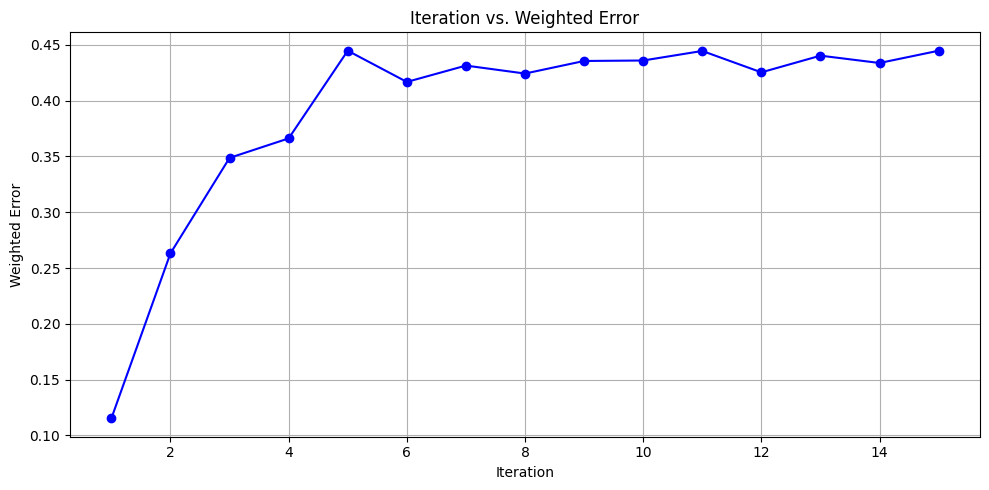

In [ ]:
# Plot iteration vs weighted error
plt.figure(figsize=(10, 5))

plt.plot(
    range(1, adaboost_model.n_estimators + 1),
    adaboost_model.weighted_errors,
    marker="o",
    color="blue",
)
plt.title("Iteration vs. Weighted Error")
plt.xlabel("Iteration")
plt.ylabel("Weighted Error")
plt.grid(True)

plt.tight_layout()
plt.show()

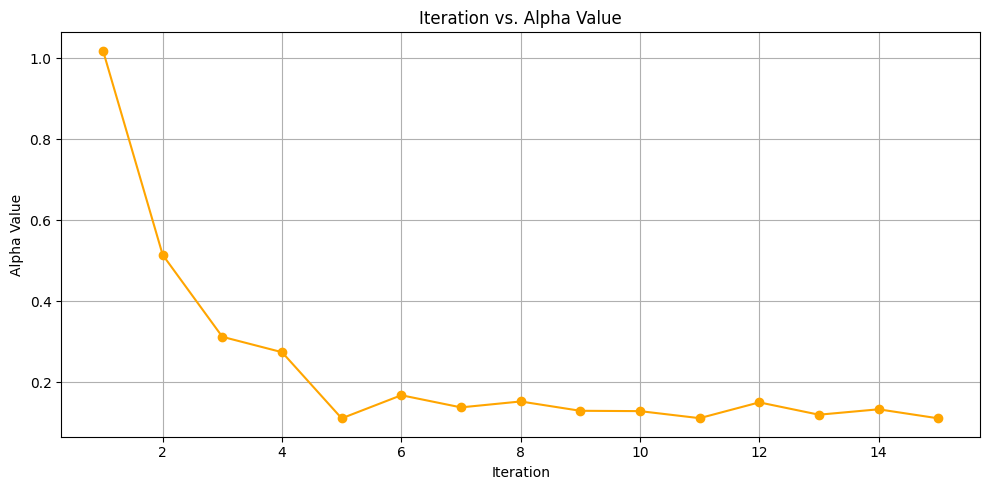

In [ ]:
# Plot iteration vs alpha
plt.figure(figsize=(10, 5))

plt.plot(
    range(1, adaboost_model.n_estimators + 1),
    adaboost_model.alphas,
    marker="o",
    color="orange",
)
plt.title("Iteration vs. Alpha Value")
plt.xlabel("Iteration")
plt.ylabel("Alpha Value")
plt.grid(True)

plt.tight_layout()
plt.show()

#### 3. Finally report:

- Train accuracy
- Test accuracy
- Confusion matrix
- Short interpretation of weight evolution


In [ ]:
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay

In [ ]:
# Make predictions on training and testing data

y_pred_train = adaboost_model.predict(X_train)
y_pred_test = adaboost_model.predict(X_test)

In [ ]:
# Accuracy scores

train_accuracy = accuracy_score(y_train, y_pred_train)
test_accuracy = accuracy_score(y_test, y_pred_test)

print(f"Manual AdaBoost (T=15) Train Accuracy: {train_accuracy:.4f}")
print(f" Manual AdaBoost (T=15) Test Accuracy: {test_accuracy:.4f}")

Manual AdaBoost (T=15) Train Accuracy: 0.9157
 Manual AdaBoost (T=15) Test Accuracy: 0.9184


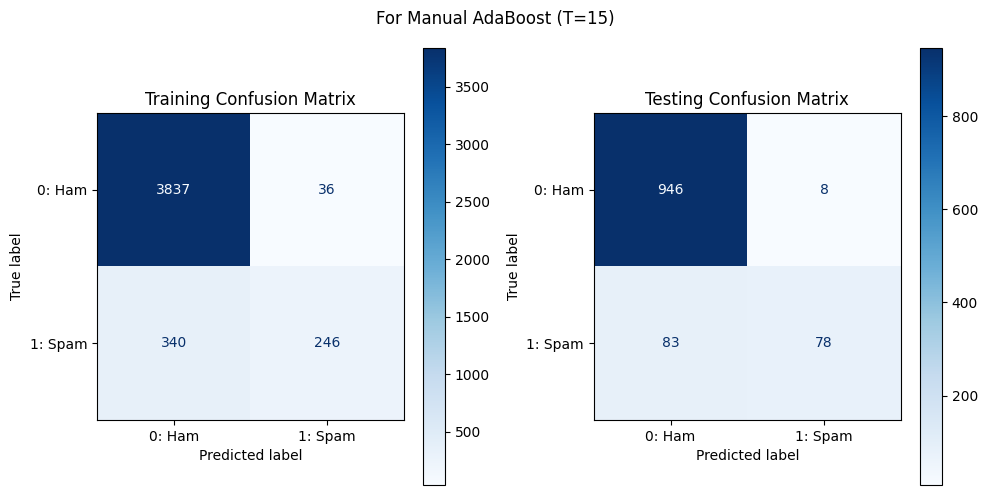

In [ ]:
# Confusion matrices

cm_train = confusion_matrix(y_train, y_pred_train)
cm_test = confusion_matrix(y_test, y_pred_test)

plt.figure(figsize=(10, 5))
plt.suptitle("For Manual AdaBoost (T=15)")

plt.subplot(1, 2, 1)
disp_train = ConfusionMatrixDisplay(
    confusion_matrix=cm_train, display_labels=["0: Ham", "1: Spam"]
)
disp_train.plot(cmap=plt.cm.Blues, ax=plt.gca())
plt.title("Training Confusion Matrix")

plt.subplot(1, 2, 2)
disp_test = ConfusionMatrixDisplay(
    confusion_matrix=cm_test, display_labels=["0: Ham", "1: Spam"]
)
disp_test.plot(cmap=plt.cm.Blues, ax=plt.gca())
plt.title("Testing Confusion Matrix")

plt.tight_layout()
plt.show()

**Evolution of AdaBoost weights with iteration:-**

- At start all samples share equal weight i.e. each stump sees the dataset uniformly.

- After each iteration AdaBoost increases weights for samples the current stump misclassifies and decreases weights for correctly classified ones. This forces the next stump to focus more on the “hard” examples.

- Over iterations weights become concentrated on a small subset of difficult / noisy / borderline samples; the ensemble learns to correct previous mistakes but can also over-emphasize mislabeled or ambiguous examples.

- Weighted error per stump and α (alpha) reflect this: lower weighted error yields larger alpha (stronger influence), while errors near 0.5 give small/negative alpha and trigger early stopping.

- In this run the iterative reweighting improved overall accuracy compared to a single stump and reduced many initial mistakes, but a few hard samples remained, showing the expected trade‑off between focusing on true hard cases vs. amplifying noise.


### **Part D — Sklearn AdaBoost**


#### 1. Train:

```
AdaBoostClassifier(
    base_estimator=DecisionTreeClassifier(max_depth=1),
    n_estimators=100,
    learning_rate=0.6
)
```


In [ ]:
from sklearn.ensemble import AdaBoostClassifier

In [ ]:
# Instantiate and train the AdaBoost model

clf = AdaBoostClassifier(
    estimator=DecisionTreeClassifier(max_depth=1, random_state=42),
    n_estimators=100,
    learning_rate=0.6,
    random_state=42,
)
clf.fit(X_train, y_train)


AdaBoostClassifier(estimator=DecisionTreeClassifier(max_depth=1,
                                                    random_state=42),
                   learning_rate=0.6, n_estimators=100, random_state=42)

#### 2. Report:

- Train accuracy
- Test accuracy
- Confusion matrix
- Compare performance with manual implementation


In [ ]:
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay

In [ ]:
# Make predictions on training and testing data

y_pred_train = clf.predict(X_train)
y_pred_test = clf.predict(X_test)

In [ ]:
# Accuracy scores

train_accuracy = accuracy_score(y_train, y_pred_train)
test_accuracy = accuracy_score(y_test, y_pred_test)

print(f"SKlearn AdaBoost (T=100) Train Accuracy: {train_accuracy:.4f}")
print(f" SKlearn AdaBoost (T=100) Test Accuracy: {test_accuracy:.4f}")

SKlearn AdaBoost (T=100) Train Accuracy: 0.9206
 SKlearn AdaBoost (T=100) Test Accuracy: 0.9193


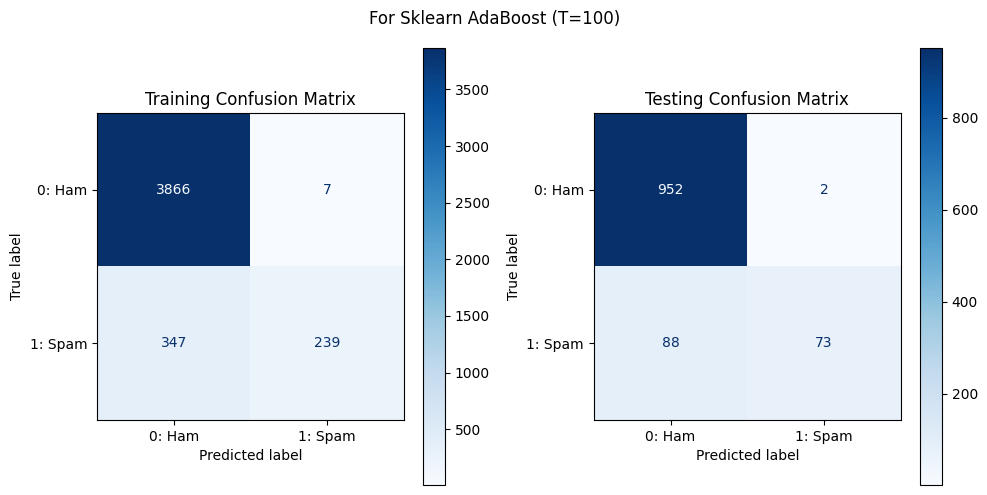

In [ ]:
# Confusion matrices

cm_train = confusion_matrix(y_train, y_pred_train)
cm_test = confusion_matrix(y_test, y_pred_test)

plt.figure(figsize=(10, 5))
plt.suptitle("For Sklearn AdaBoost (T=100)")

plt.subplot(1, 2, 1)
disp_train = ConfusionMatrixDisplay(
    confusion_matrix=cm_train, display_labels=["0: Ham", "1: Spam"]
)
disp_train.plot(cmap=plt.cm.Blues, ax=plt.gca())
plt.title("Training Confusion Matrix")

plt.subplot(1, 2, 2)
disp_test = ConfusionMatrixDisplay(
    confusion_matrix=cm_test, display_labels=["0: Ham", "1: Spam"]
)
disp_test.plot(cmap=plt.cm.Blues, ax=plt.gca())
plt.title("Testing Confusion Matrix")

plt.tight_layout()
plt.show()

**Comparing with Manual Implementation:-**

Both AdaBoost implementations (manual and sklearn) significantly improve upon the single Decision Stump baseline, as both dramatically reduced false positives.

The scikit-learn version with more estimators and a tuned learning rate achieves slightly better overall accuracy and false negative reduction, while the manual implementation, despite having fewer estimators, excels in minimizing false positives.

**Differences Between Manual and SKlearn AdaBoost:-**

1. **Number of Estimators:** While the manual implementation used T=15 weak learners, the sklearn version used n_estimators=100. Generally, more estimators can lead to better performance, up to a point, but also increase computation time.

2. **Learning Rate:** The sklearn version explicitly uses a learning_rate=0.6. However, manual implementation implicitly has a learning rate of 1.0 (as the alpha values are directly applied). A learning rate scales the contribution of each weak learner. A lower learning rate often requires more estimators but can lead to a more robust model and prevent overfitting.


3. **Performance on Ham vs. Spam:** The manual AdaBoost (T=15) shows a remarkable reduction in false positives (2) compared to scikit-learn's (5), while scikit-learn slightly edges it out in reducing false negatives (85 vs 88). This suggests that the manual implementation, with fewer estimators but effectively a higher learning rate, might be slightly more conservative in labeling messages as spam, leading to fewer false alarms but possibly missing a few more actual spam messages.

## **Q2. UCI Heart Disease Dataset**

---


You will use the UCI Heart Disease dataset (available in `sklearn.datasets`).

This dataset contains patient medical features used to predict heart disease.

| Feature  | Meaning                              |
| -------- | ------------------------------------ |
| Age      | Patient age                          |
| Sex      | Gender (1 = male, 0 = female)        |
| Cp       | Chest pain type (0–3)                |
| Trestbps | Resting blood pressure               |
| Chol     | Serum cholesterol (mg/dl)            |
| Fbs      | Fasting blood sugar >120 mg/dl (1/0) |
| Restecg  | Resting ECG results                  |
| Thalach  | Max heart rate achieved              |
| Exang    | Exercise-induced angina (1/0)        |
| Oldpeak  | ST depression induced by exercise    |
| Slope    | Slope of peak exercise ST segment    |
| Ca       | # of major vessels (0–3)             |
| Thal     | Thallium stress test result (0–3)    |

**Target:**

1 = heart disease present

0 = No heart disease


### **Part A — Baseline Model (Weak Learner)**


#### 1. Load the dataset and preprocess (handle categorical features, scaling if needed)


In [52]:
# Loading dataset
from sklearn.datasets import fetch_openml

heart = fetch_openml(name="heart-statlog", version=1, as_frame=True)
X = heart.data
y = heart.target

X.columns = [
    "Age",
    "Sex",
    "Cp",
    "Trestbps",
    "Chol",
    "Fbs",
    "Restecg",
    "Thalach",
    "Exang",
    "Oldpeak",
    "Slope",
    "Ca",
    "Thal"
]
y = y.map({"present": 1, "absent": 0})

X.head()

,Age,Sex,Cp,Trestbps,Chol,Fbs,Restecg,Thalach,Exang,Oldpeak,Slope,Ca,Thal
0,70,1,4,130,322,0,2,109,0,2.4,2,3,3
1,67,0,3,115,564,0,2,160,0,1.6,2,0,7
2,57,1,2,124,261,0,0,141,0,0.3,1,0,7
3,64,1,4,128,263,0,0,105,1,0.2,2,1,7
4,74,0,2,120,269,0,2,121,1,0.2,1,1,3


In [64]:
# Types of features in the dataframe

attr_types = {
    "real": [1, 4, 5, 8, 10, 12],
    "ordered": [11],
    "binary": [2, 6, 9],
    "nominal": [3, 7, 13],
}

In [67]:
# Handling categorical features

nominal_feats = X.columns[[col_ind-1 for col_ind in attr_types["nominal"]]]

X_nom = pd.get_dummies(X, columns=nominal_feats, dtype=int, drop_first=True)
X_nom.head()

,Age,Sex,Trestbps,Chol,Fbs,Thalach,Exang,Oldpeak,Slope,Ca,Cp_2,Cp_3,Cp_4,Restecg_1,Restecg_2,Thal_6,Thal_7
0,70,1,130,322,0,109,0,2.4,2,3,0,0,1,0,1,0,0
1,67,0,115,564,0,160,0,1.6,2,0,0,1,0,0,1,0,1
2,57,1,124,261,0,141,0,0.3,1,0,1,0,0,0,0,0,1
3,64,1,128,263,0,105,1,0.2,2,1,0,0,1,0,0,0,1
4,74,0,120,269,0,121,1,0.2,1,1,1,0,0,0,1,0,0


In [ ]:
# Scaling will not be done as it doesn't affect split threshold of scale-invariant weak Decision Stump

#### 2. Train **one Decision Stump** (max_depth = 1)


In [70]:
# Train-test split
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_nom, y, test_size=0.2, random_state=42)

print(f"Training records: {X_train.shape[0]}")
print(f" Testing records: {X_test.shape[0]}")

Training records: 216
 Testing records: 54


In [71]:
from sklearn.tree import DecisionTreeClassifier

In [72]:
# Training Decision stump

stump = DecisionTreeClassifier(max_depth=1, random_state=42)
stump.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=1, random_state=42)

#### 3. Report:

- Training & test accuracy
- Confusion matrix
- Classification report


In [73]:
# Predicting test values for decision stump

y_pred_stump_train = stump.predict(X_train)
y_pred_stump_test = stump.predict(X_test)

In [74]:
# Calculating accuracies
from sklearn.metrics import accuracy_score

stump_train_accuracy = accuracy_score(y_train, y_pred_stump_train)
stump_test_accuracy = accuracy_score(y_test, y_pred_stump_test)

print("FOR SINGLE DECISION STUMP:-")
print(f"\tTrain accuracy: {stump_train_accuracy:.4f}")
print(f"\t Test accuracy: {stump_test_accuracy:.4f}")

FOR SINGLE DECISION STUMP:-
	Train accuracy: 0.7639
	 Test accuracy: 0.7037


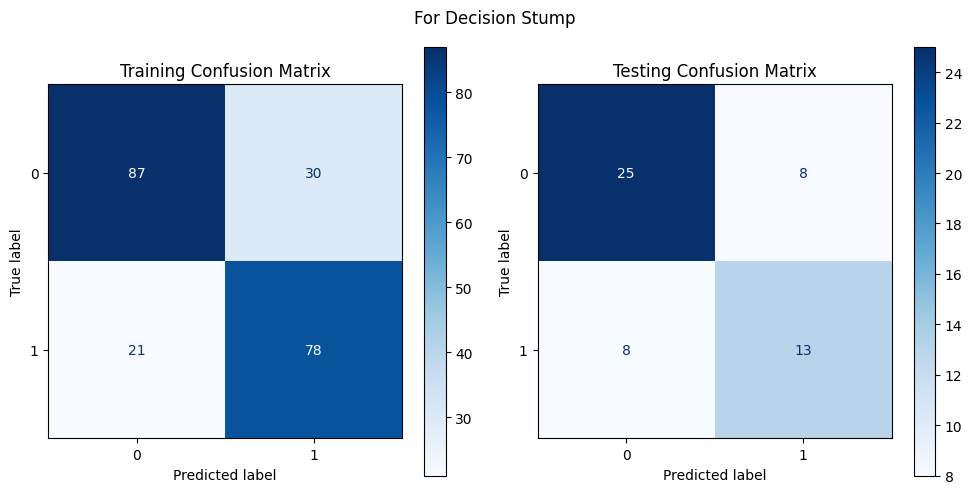

In [75]:
# Confusion matrices
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm_stump_train = confusion_matrix(y_train, y_pred_stump_train)
cm_stump_test = confusion_matrix(y_test, y_pred_stump_test)

plt.figure(figsize=(10, 5))

plt.suptitle("For Decision Stump")

plt.subplot(1, 2, 1)
disp_stump_train = ConfusionMatrixDisplay(
    confusion_matrix=cm_stump_train, display_labels=stump.classes_
)
disp_stump_train.plot(cmap=plt.cm.Blues, ax=plt.gca())
plt.title("Training Confusion Matrix")

plt.subplot(1, 2, 2)
disp_stump_test = ConfusionMatrixDisplay(
    confusion_matrix=cm_stump_test, display_labels=stump.classes_
)
disp_stump_test.plot(cmap=plt.cm.Blues, ax=plt.gca())
plt.title("Testing Confusion Matrix")

plt.tight_layout()
plt.show()

In [78]:
# Classification report
from sklearn.metrics import classification_report

print("\nFOR SINGLE DECISION STUMP:-")
print(classification_report(y_test, y_pred_stump_test, target_names=["No heart disease", "Heart disease present"]))


FOR SINGLE DECISION STUMP:-
                       precision    recall  f1-score   support

     No heart disease       0.76      0.76      0.76        33
Heart disease present       0.62      0.62      0.62        21

             accuracy                           0.70        54
            macro avg       0.69      0.69      0.69        54
         weighted avg       0.70      0.70      0.70        54



#### 4. What shortcomings do you observe in a single stump?


Again, the baseline decision stump underfits on the data, due to:

1. **Limited Decision Boundary:** A decision stump can only make a single split based on one feature. This means it can only create a linear decision boundary parallel to one of the axes. Real-world medical conditions like heart disease are often influenced by complex interactions between multiple factors (age, cholesterol, blood pressure, etc.), requiring much more intricate and non-linear decision boundaries that a single stump cannot capture.

2. **Inability to Capture Feature Interactions:** The presence or absence of heart disease is rarely determined by a single isolated feature. For instance, high cholesterol might be more critical for an older patient than a younger one. A decision stump cannot model these interactions effectively.

3. **Susceptibility to Noise:** If the single split happens to be on a noisy feature or a feature that is not strongly correlated with the target variable, the stump's performance will be significantly degraded. It lacks the robustness that comes from combining multiple weak learners.

### **Part B — Train AdaBoost**


#### 1. Train **AdaBoostClassifier** using decision stumps as base learners


#### 2. Use:

- n_estimators = [5, 10, 25, 50, 100]
- learning_rate = [0.1, 0.5, 1.0]


#### 3. For each combination:

- Train model
- Compute accuracy on test set


#### 4. Plot:

- n_estimators vs accuracy for each learning_rate


#### 5. Identify best config (highest accuracy)


### **Part C — Misclassification Pattern**


#### 1. For the best model, collect the **sample weights** and **prediction errors** at each iteration.


#### 2. Plot:

- Weak learner error vs iteration
- Sample weight distribution after final boosting stage


#### 3. Explain:

- Which samples got highest weights?
- Why does AdaBoost focus on them?


### **Part D — Visual Explainability**


#### 1. Plot feature importance from AdaBoost.


#### 2. Identify top 5 most important features.


#### 3. Explain why these features may matter medically.


## **Q3. WISDM Smartphone & Watch Motion Sensor Dataset**

---


(Available on UCI / Kaggle → WISDM_ar_v1.1_raw.txt)

**Dataset Description**

Collected from smartphones & smartwatches using **accelerometer & gyroscope**.

| Attribute       | Description                                                 |
| --------------- | ----------------------------------------------------------- |
| user_id         | Person ID                                                   |
| Activity        | type of physical activity (e.g., walking, jogging, sitting) |
| Timestamp       | time in milliseconds                                        |
| sensor readings | acceleration or gyroscope X, Y, Z values                    |

Target prediction task:

- Convert activity into binary label:
  - 1 = vigorous motion (Jogging, Upstairs)
  - 0 = light/static motion (Walking, Sitting, Standing, Downstairs)

We will use only **accelerometer features** (X, Y, Z).

**Goal**

Build an activity classifier using **AdaBoost** to distinguish between **vigorous vs normal activity** based on smartphone sensor accelerations.


### **Part A — Data Preparation**


#### 1. Load the dataset (WISDM_ar_v1.1_raw.txt)


#### 2. Extract only numeric accelerometer X, Y, Z columns


#### 3. Create activity label as binary:

| Activity Type          | Label |
| ---------------------- | ----- |
| Jogging, Up            | 1     |
| Walk, Sit, Stand, Down | 0     |


#### 4. Handle missing/dirty entries


#### 5. Train-test split (70/30)


### **Part B — Weak Classifier Baseline**


#### 1. Train a **Decision Stump**:

`DecisionTreeClassifier(max_depth=1)`


#### 2. Report:

- Accuracy (train + test)
- Confusion matrix
- Interpretation of stump result


### **Part C — Manual AdaBoost (T = 20 rounds)**


#### 1. Write your own AdaBoost **with full weight tracking**.

At **each iteration**, print:

- Iteration number
- Misclassified sample indices
- Weights of misclassified samples

**Note:** Normalize weights after update.


#### 2. Also plot:

- Boosting round vs error
- Boosting round vs alpha


#### 3. Finally report:

- Train accuracy
- Test accuracy
- Confusion matrix
- Interpretation: how weights shifted over time


### **Part D — Sklearn AdaBoost**


#### 1. Train:

```
AdaBoostClassifier(
    base_estimator = DecisionTreeClassifier(max_depth=1),
    n_estimators = 100,
    learning_rate = 1.0
)
```


#### 2. Report:

- Train/Test accuracy
- Confusion matrix
- Compare with your manual implementation
